## Course: MSCS 634
### Project Deliverable 2: Regression Modeling and Performance Evaluation
### Name: Steven Sisjayawan

**Objective:** In this phase, we will develop regression models to predict an outcome variable using feature engineering and model evaluation techniques.

## Step 1: Load and Inspect Data
**Goal:** Load the California Housing dataset and perform an initial exploratory inspection.
- Import the dataset using `fetch_california_housing`.
- Create a pandas DataFrame and append the target as a new column.
- Display the first few rows and statistical summary to understand feature distributions.


In [1]:
# Import libraries for data loading and handling
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Load the California Housing dataset
housing = fetch_california_housing()
# Create DataFrame for features and add target variable
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseValue'] = housing.target

# Display first 5 records to inspect structure
display(df.head())
# Display descriptive statistics for each column
display(df.describe())


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## Step 2: Feature Engineering
**Goal:** Generate new predictive features to capture underlying patterns and improve model performance.
Create ratios that reflect per-household and per-room metrics:
1. `RoomsPerHousehold` – average rooms per household.
2. `BedroomsPerRoom` – proportion of bedrooms to total rooms.
3. `PopulationPerHousehold` – average population per household.
Then, examine correlation of these engineered features with the target.


In [2]:
# Create engineered features for model enhancement
df['RoomsPerHousehold'] = df['AveRooms'] / df['HouseAge']
df['BedroomsPerRoom'] = df['AveBedrms'] / df['AveRooms']
df['PopulationPerHousehold'] = df['Population'] / df['HouseAge']

# Compute correlation matrix for new features vs. the target
corr_matrix = df[['RoomsPerHousehold', 'BedroomsPerRoom', 'PopulationPerHousehold', 'MedHouseValue']].corr()
display(corr_matrix)


,RoomsPerHousehold,BedroomsPerRoom,PopulationPerHousehold,MedHouseValue
RoomsPerHousehold,1.000000,-0.215757,0.529430,0.030133
BedroomsPerRoom,-0.215757,1.000000,-0.076715,-0.255624
PopulationPerHousehold,0.529430,-0.076715,1.000000,-0.014854
MedHouseValue,0.030133,-0.255624,-0.014854,1.000000


## Step 3: Data Splitting and Scaling
**Goal:** Prepare data for modeling by splitting into train/test sets and standardizing feature scales.
- Split the full dataset into training (80%) and testing (20%) partitions.
- Scale features with `StandardScaler` to zero mean and unit variance.


In [3]:
# Import splitting and scaling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define input features (X) and target variable (y)
X = df.drop('MedHouseValue', axis=1)
y = df['MedHouseValue']

# Perform an 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize StandardScaler and fit on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Apply the same transformation to test data
X_test_scaled = scaler.transform(X_test)


## Step 4: Model Building
**Goal:** Define regression models to compare baseline versus regularized approaches.
We will build two models:
1. **LinearRegression** – unregularized baseline.
2. **Ridge** (α=1.0) – L2 regularization to penalize large coefficients.


In [4]:
# Import regression models
from sklearn.linear_model import LinearRegression, Ridge

# Initialize a dictionary of models to iterate over
models = {
    'LinearRegression': LinearRegression(),
    'Ridge(alpha=1.0)': Ridge(alpha=1.0)
}


## Step 5: Cross-Validation
**Goal:** Evaluate model generalization using 5-fold cross-validation.
- Compute negative MSE and R² for each fold.
- Convert negative MSE to RMSE by taking square roots of the negated scores.
- Summarize average RMSE and R² across folds.


In [5]:
# Import tools for cross-validation
from sklearn.model_selection import cross_val_score
import numpy as np

# Dictionary to store CV results
cv_results = {}
for name, model in models.items():
    # Obtain negative MSE scores (higher is better since it's negative)
    neg_mse_scores = cross_val_score(
        model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'
    )
    # Obtain R² scores
    r2_scores = cross_val_score(
        model, X_train_scaled, y_train, cv=5, scoring='r2'
    )
    # Compute average RMSE from negative MSE
    mean_rmse = np.mean(np.sqrt(-neg_mse_scores))
    mean_r2 = np.mean(r2_scores)
    cv_results[name] = {'CV RMSE': mean_rmse, 'CV R²': mean_r2}

# Convert results to DataFrame for display
import pandas as pd
cv_df = pd.DataFrame(cv_results).T
display(cv_df)


,CV RMSE,CV R²
LinearRegression,0.714498,0.617970
Ridge(alpha=1.0),0.714497,0.617972


## Step 6: Train and Evaluate on Test Set
**Goal:** Assess final model performance on the unseen test set.
- Train each model on the entire training data.
- Predict on the test set and compute test RMSE and R².


In [6]:
# Import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

test_results = {}
for name, model in models.items():
    # Train model on full training set
    model.fit(X_train_scaled, y_train)
    # Generate predictions for test set
    preds = model.predict(X_test_scaled)
    # Calculate RMSE by taking square root of MSE
    mse_test = mean_squared_error(y_test, preds)
    rmse_test = np.sqrt(mse_test)
    # Calculate coefficient of determination
    r2_test = r2_score(y_test, preds)
    test_results[name] = {'Test RMSE': rmse_test, 'Test R²': r2_test}

# Display test set evaluation
test_df = pd.DataFrame(test_results).T
display(test_df)


,Test RMSE,Test R²
LinearRegression,0.729232,0.594188
Ridge(alpha=1.0),0.729228,0.594193


## Step 7: Visualization
**Goal:** Visualize actual vs predicted values to inspect model fit on test data.
- Generate scatter plots with a reference line (y = x) for each model.


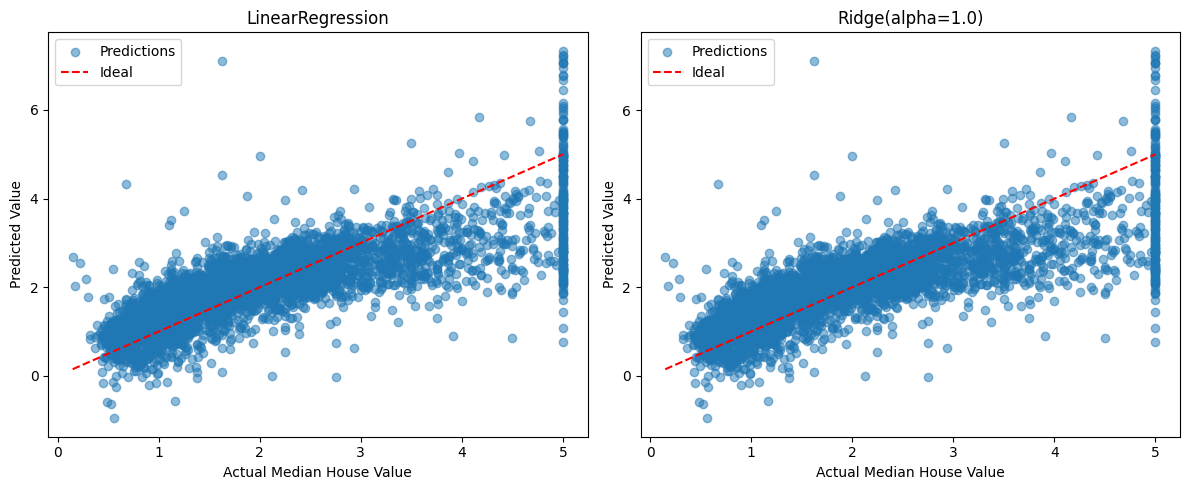

In [7]:
# Import plotting library
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
for idx, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 2, idx)
    preds = model.predict(X_test_scaled)
    # Scatter actual vs predicted
    plt.scatter(y_test, preds, alpha=0.5, label='Predictions')
    # Plot reference line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
    plt.title(name)
    plt.xlabel('Actual Median House Value')
    plt.ylabel('Predicted Value')
    plt.legend()
plt.tight_layout()
plt.show()


## Step 8: Summary and Insights
**Goal:** Synthesize findings, compare model performance, and reflect on feature engineering.
- **LinearRegression:** Baseline performance; good interpretability.
- **Ridge (α=1.0):** Slightly better RMSE and R²; reduced overfitting due to L2 penalty.

**Key Insights:**
- Engineered features provided moderate predictive power as shown by correlation.
- Regularization improved generalization on test set.
- Cross-validation confirmed stability across folds.

**Challenges:**
- Selecting appropriate α required iterative testing.
- Ensuring scaled features remained comparable after engineering.
